
Processing Scenario B - Separate Model Comparison
✓ Loaded Lerp: 260937 imputed points

Lerp        
  MAE:    45.20 mg/dL
  Bias:  -42.66 mg/dL
  GT σ:   61.75 | Lerp σ:   40.81
✓ Loaded SAITS: 260937 imputed points

SAITS       
  MAE:    41.91 mg/dL
  Bias:  -35.84 mg/dL
  GT σ:   61.75 | SAITS σ:   26.20
✓ Loaded SCINet: 260937 imputed points

SCINet      
  MAE:    44.30 mg/dL
  Bias:  -36.05 mg/dL
  GT σ:   61.75 | SCINet σ:   20.50
✓ Loaded FreTS: 260937 imputed points

FreTS       
  MAE:    44.81 mg/dL
  Bias:  -27.62 mg/dL
  GT σ:   61.75 | FreTS σ:   19.06

✓ Plot saved to: New_DAY_NIGHT/calibration_separate_ratio_B_3.png


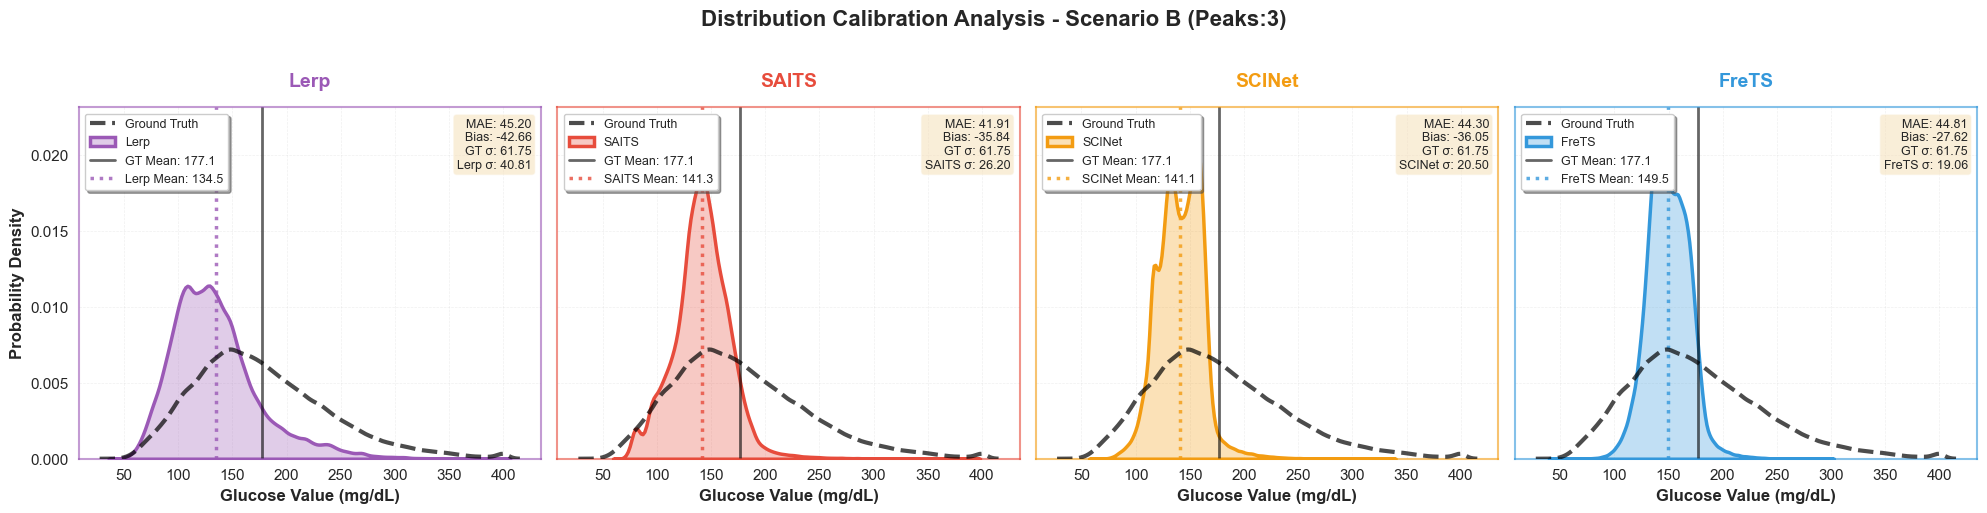

In [97]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# Configuration
# ============================================================================
BASE_PATH = "New_DAY_NIGHT"
DATASET = "simulate"
RATIO = "3"
MODELS = ["Lerp", "SAITS", "SCINet", "FreTS"]  # Updated with your actual models
SCENARIOS = ["B"]

# Professional color scheme
COLOR_MAP = {
    "Lerp": "#9B59B6",      # Purple
    "SAITS": "#E74C3C",     # Red
    "SCINet": "#F39C12",    # Orange
    "FreTS": "#3498DB",     # Blue
}

# ============================================================================
# Data Loading
# ============================================================================
def load_scenario_data(base_path, dataset, model, scenario, ratio):
    """Load imputation results for a specific scenario and model."""
    filepath = os.path.join(
        base_path, dataset, "Mixed", model, 
        f"{scenario}_{ratio}_result_prediction.npy"
    )
    
    if not os.path.exists(filepath):
        print(f"⚠️  File not found: {filepath}")
        return None, None
    
    try:
        data = np.load(filepath)
        ground_truth = data[:, :, 0]
        imputed = data[:, :, 1]
        mask = data[:, :, 2]
        
        # Extract only masked values
        is_masked = mask == 1
        gt_masked = ground_truth[is_masked]
        imp_masked = imputed[is_masked]
        
        print(f"✓ Loaded {model}: {len(gt_masked)} imputed points")
        return gt_masked, imp_masked
    
    except Exception as e:
        print(f"❌ Error loading {filepath}: {e}")
        return None, None

# ============================================================================
# Plotting
# ============================================================================
def plot_scenario_calibration_separate():
    """Create separate calibration plots for each model in one row."""
    
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.size'] = 11
    
    n_models = len(MODELS)
    fig, axes = plt.subplots(
        1, n_models,
        figsize=(5 * n_models, 5),
        sharey=True
    )
    
    if n_models == 1:
        axes = [axes]
    
    scenario = SCENARIOS[0]  # Using first scenario
    
    print(f"\n{'='*60}")
    print(f"Processing Scenario {scenario} - Separate Model Comparison")
    print(f"{'='*60}")
    
    # Store ground truth for comparison (load once)
    gt_reference = None
    
    for idx, model in enumerate(MODELS):
        ax = axes[idx]
        
        # Load data for this model
        gt_values, imp_values = load_scenario_data(
            BASE_PATH, DATASET, model, scenario, RATIO
        )
        
        if gt_values is None:
            ax.text(0.5, 0.5, f"No data for {model}", 
                   ha='center', va='center', transform=ax.transAxes)
            continue
        
        # Store first valid ground truth
        if gt_reference is None:
            gt_reference = gt_values
        
        # Calculate statistics
        gt_mean = np.mean(gt_values)
        gt_std = np.std(gt_values)
        imp_mean = np.mean(imp_values)
        imp_std = np.std(imp_values)
        mae = np.mean(np.abs(imp_values - gt_values))
        bias = imp_mean - gt_mean
        
        # Plot Ground Truth
        sns.kdeplot(
            gt_values, 
            ax=ax, 
            color="black", 
            linestyle="--", 
            linewidth=3, 
            label="Ground Truth", 
            zorder=10,
            alpha=0.7
        )
        
        # Plot Model Distribution
        model_color = COLOR_MAP.get(model, "#34495E")
        sns.kdeplot(
            imp_values, 
            ax=ax, 
            color=model_color, 
            fill=True,
            alpha=0.3,
            linewidth=2.5, 
            label=model
        )
        
        # Add vertical lines for means
        ax.axvline(
            gt_mean, 
            color="black", 
            linestyle="-", 
            linewidth=2,
            alpha=0.6,
            label=f"GT Mean: {gt_mean:.1f}"
        )
        
        ax.axvline(
            imp_mean, 
            color=model_color, 
            linestyle=":", 
            linewidth=2.5,
            alpha=0.8,
            label=f"{model} Mean: {imp_mean:.1f}"
        )
        
        # Add text box with statistics
        stats_text = (
            f"MAE: {mae:.2f}\n"
            f"Bias: {bias:+.2f}\n"
            f"GT σ: {gt_std:.2f}\n"
            f"{model} σ: {imp_std:.2f}"
        )
        
        ax.text(
            0.98, 0.97, stats_text,
            transform=ax.transAxes,
            fontsize=9,
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        )
        
        # Format subplot
        ax.set_title(
            f"{model}",
            fontsize=14, 
            fontweight='bold',
            pad=15,
            color=model_color
        )
        ax.set_xlabel("Glucose Value (mg/dL)", fontsize=12, fontweight='bold')
        
        if idx == 0:
            ax.set_ylabel("Probability Density", fontsize=12, fontweight='bold')
        
        # Legend
        legend = ax.legend(
            loc='upper left',
            frameon=True,
            fancybox=True,
            shadow=True,
            fontsize=9
        )
        
        # Grid styling
        ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Spine styling
        for spine in ax.spines.values():
            spine.set_linewidth(1.5)
            spine.set_color(model_color)
            spine.set_alpha(0.6)
        
        # Print statistics
        print(f"\n{model:12s}")
        print(f"  MAE:  {mae:7.2f} mg/dL")
        print(f"  Bias: {bias:+7.2f} mg/dL")
        print(f"  GT σ: {gt_std:7.2f} | {model} σ: {imp_std:7.2f}")
    
    # Add main title
    fig.suptitle(
        # f"Distribution Calibration Analysis - Scenario {scenario}",
        f"Distribution Calibration Analysis - Scenario {scenario} (Peaks:{str(RATIO)})",
        fontsize=16,
        fontweight='bold',
        y=1.02
    )
    
    plt.tight_layout()
    
    # Save option
    output_path = os.path.join(BASE_PATH, f"calibration_separate_ratio_{scenario}_{RATIO}.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"\n✓ Plot saved to: {output_path}")
    
    plt.show()

# ============================================================================
# Main
# ============================================================================
if __name__ == "__main__":
    plot_scenario_calibration_separate()

# Plot Comparison

In [2]:
"""
Imputation Comparison Plotter
Visualises ground truth vs. model imputations across masked (gap) regions.
"""

import os
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt


BASELINES = {"Mean", "Median", "LOCF", "Lerp"}

COLOR_MAP = {
    "Ground Truth": "#000000",  # Black (colorblind-safe)
    # Baselines (colorblind-safe palette)
    "Mean":      "#7A7A7A",
    "Median":    "#B3B3B3",
    "LOCF":      "#1F1F1F",
    "Lerp":      "#DE8F05",     # Orange (colorblind-safe)
    # Deep-learning models (colorblind-safe palette)
    "SAITS":     "#0173B2",     # Blue (colorblind-safe)
    "FreTS":     "#1976D2",
    "SCINet":    "#029E73",     # Green (colorblind-safe)
    "TimeMixer": "#388E3C",
    "TSLANet":   "#5D4037",
    "TEFN":      "#00796B",
    "TOTEM":     "#C2185B",
    "GPT4TS":    "#FBC02D",
}


# ──────────────────────────── Helpers ──────────────────────────────────

def build_file_path(base_path: str, dataset: str, model: str,
                    scenario: str, ratio: str) -> str:
    """Build the .npy path for a given dataset / model / scenario / ratio.

    Parameters
    ----------
    dataset : str
        One of ``"simulate"``, ``"pedap"``, or ``"none_pedap"``.
    """
    return os.path.join(base_path, dataset, "Mixed", model,
                        f"{scenario}_{ratio}_result_prediction.npy")


def load_sample(file_path: str, sample_idx: int) -> Tuple[np.ndarray, ...]:
    """Return (ground_truth, imputation, mask) for a single sample."""
    data = np.load(file_path)
    return (
        data[sample_idx, :, 0],
        data[sample_idx, :, 1],
        data[sample_idx, :, 2],
    )


def find_mask_segments(mask: np.ndarray) -> List[Tuple[int, int]]:
    """Detect contiguous masked regions as (start, end) pairs."""
    bounded = np.concatenate(([0], mask, [0]))
    diffs = np.diff(bounded)
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0]
    return list(zip(starts, ends))


def get_style(model: str, idx: int, fallback_colors: np.ndarray):
    """Return (color, linestyle, linewidth) for a given model."""
    color = COLOR_MAP.get(model, fallback_colors[idx])
    is_baseline = model in BASELINES
    ls = "--" if is_baseline else "-"
    lw = 1.5  # All model lines are 1.5pt
    return color, ls, lw


# ──────────────────────────── Plotting ─────────────────────────────────

def plot_ground_truth(ax: plt.Axes, gt: np.ndarray,
                      segments: List[Tuple[int, int]]) -> None:
    """Plot the ground-truth signal and shade each masked region."""
    ax.plot(gt, color="black", lw=2.0, zorder=100, label="Ground Truth")
    for idx, (start, end) in enumerate(segments):
        label = "Masked Region" if idx == 0 else None
        ax.axvspan(start, end, color="#fff3cd", alpha=0.5, label=label)


def plot_meal_indicators(ax: plt.Axes,
                         segments: List[Tuple[int, int]]) -> None:
    """Draw a vertical dashed line at each mask-segment start (Scenario B only)."""
    for idx, (start, _end) in enumerate(segments):
        ax.axvline(start, color="k", linestyle=":", linewidth=2.0,
                   alpha=0.9, zorder=200)


def plot_imputation(ax: plt.Axes, imp: np.ndarray,
                    segments: List[Tuple[int, int]], total_len: int,
                    model: str, color, ls: str, lw: float) -> None:
    """Plot imputed values only inside (and one step beyond) each gap."""
    for j, (start, end) in enumerate(segments):
        p_start = max(0, start - 1)
        p_end = min(total_len, end + 1)
        x = np.arange(p_start, p_end)
        label = model if j == 0 else None
        ax.plot(x, imp[p_start:p_end], color=color, ls=ls, lw=lw,
                alpha=0.8, label=label)


def style_axes(ax: plt.Axes, scenario: str, dataset: str,
               total_len: int) -> None:

    ax.set_xlabel("Time Steps (Whole Day)", fontsize=14)
    ax.set_ylabel("Glucose (mg/dL)", fontsize=14)
    ax.set_xlim(0, total_len)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left",
              title="Models", frameon=False, fontsize=14)


# ──────────────────────────── Main ─────────────────────────────────────

def plot_impute(cfg: dict, model_list: List[str]) -> None:
    """Generate the imputation comparison plot.

    Parameters
    ----------
    cfg : dict
        Must contain the keys ``base_path``, ``dataset``, ``scenario``,
        ``ratio``, ``sample_idx``, ``total_len``, and ``fig_size``.
        Optionally includes ``save_path`` to persist the figure to disk.
    model_list : list[str]
        Ordered list of model names to plot.
    """
    fallback_colors = plt.cm.tab20(np.linspace(0, 1, len(model_list)))
    fig, ax = plt.subplots(figsize=cfg["fig_size"])

    gt_plotted = False
    mask_segments: List[Tuple[int, int]] = []

    for i, model in enumerate(model_list):
        fpath = build_file_path(
            cfg["base_path"], cfg["dataset"],
            model, cfg["scenario"], cfg["ratio"],
        )
        if not os.path.exists(fpath):
            continue

        try:
            gt, imp, mask = load_sample(fpath, cfg["sample_idx"])
            color, ls, lw = get_style(model, i, fallback_colors)

            if not gt_plotted:
                mask_segments = find_mask_segments(mask)
                plot_ground_truth(ax, gt, mask_segments)
                if cfg["scenario"] == "B":
                    plot_meal_indicators(ax, mask_segments)
                gt_plotted = True

            plot_imputation(ax, imp, mask_segments, cfg["total_len"],
                            model, color, ls, lw)

        except Exception as exc:
            print(f"Error loading {model}: {exc}")

    style_axes(ax, cfg["scenario"], cfg["dataset"], cfg["total_len"])
    plt.tight_layout()

    if "save_path" in cfg:
        os.makedirs(cfg["save_path"], exist_ok=True)
        fname = (f"{cfg['dataset']}_{cfg['scenario']}-{cfg['ratio']}-"
                 f"{cfg['sample_idx']}.pdf")
        fig.savefig(os.path.join(cfg["save_path"], fname),
                    dpi=600, bbox_inches="tight")

    plt.show()

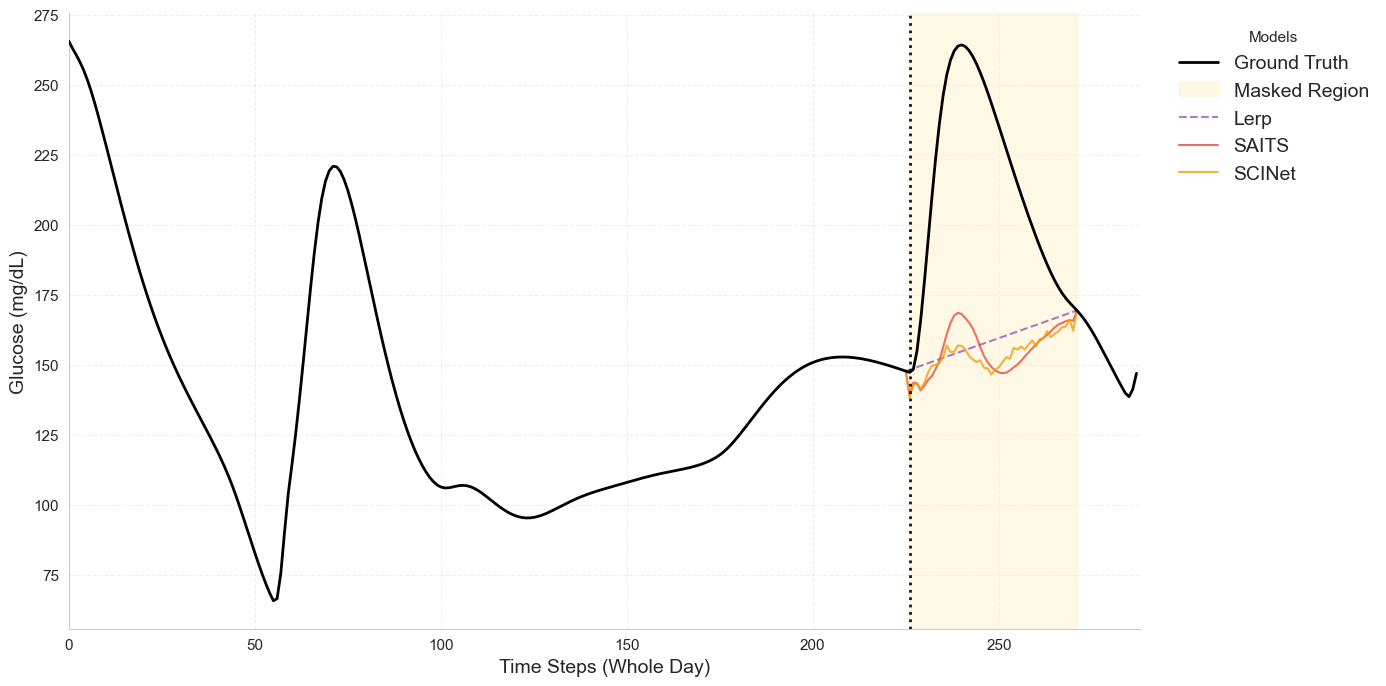

In [179]:
# ──────────────────────────── Entry Point ──────────────────────────────

CONFIG = {
    "base_path":  "New_DAY_NIGHT/",
    "dataset":    'simulate',      # "simulate" | "pedap" | "none_pedap"
    
    "scenario":   "B",
    "ratio":      "1",
    
    "sample_idx": 594,
    
    "total_len":  288,
    "fig_size":   (14, 7),
    # "save_path": "Scenario_Plots/New_Day_Night/pdf",
}

MODEL_LIST = ["Lerp", "SAITS", "SCINet"]

plot_impute(CONFIG, MODEL_LIST)


In [143]:
file_path = os.path.join('./DAY_NIGHT/simulate/Mixed/Lerp/', "C__result_prediction.npy")
for sample_idx in range(30000):

    data = np.load(file_path)
    gt   = data[sample_idx, :, 0]
    imp  = data[sample_idx, :, 1]
    mask = data[sample_idx, :, 2]
    if sum(mask) > 1:
        print(sample_idx)

86
87
129
130
135
136
137
142
143
149
150
156
157
162
163
164
169
170
176
177
183
184
189
190
191
196
197
203
204
210
211
216
217
218
223
224
230
231
237
238
243
244
245
259
260
261
264
265
266
267
268
269
270
271
273
274
275
276
277
278
280
281
284
285
287
288
293
294
300
301
302
303
307
308
311
312
313
314
315
317
318
319
320
321
322
324
325
326
327
328
329
330
334
335
336
338
339
342
343
347
348
349
351
352
353
354
355
358
359
361
362
365
366
368
369
374
375
381
382
388
389
394
395
396
397
398
401
402
408
409
411
412
415
416
421
422
423
424
425
428
429
431
432
435
436
437
438
439
448
449
450
455
456
457
458
459
469
470
471
472
473
475
476
477
489
490
492
493
498
499
500
501
502
505
506
507
508
509
512
513
514
515
516
518
519
520
525
526
527
528
529
532
533
534
535
536
539
540
541
542
543
545
546
547
548
549
552
553
554
555
556
559
560
561
562
563
566
567
568
569
570
572
573
574
575
576
579
580
581
582
583
586
587
588
589
590
591
593
594
595
596
597
599
600
601
606
607
609
610
613
61

IndexError: index 2480 is out of bounds for axis 0 with size 2480

# Generate Table in Latex

In [95]:
import pandas as pd
import glob
import re
import numpy as np

# =============== USER SETTINGS ===============
target_scenarios = ['C']          # <- ['A'] or ['B'] or ['C'] or ['A','B','C']
exclude = ['MSE', 'MAE']

file_patterns = {
    # "pedap": "DAY_NIGHT/pedap/aggregated_results_*.csv",
    "simulate": "New_DAY_NIGHT/simulate/aggregated_results_*.csv",
    # "none_pedap": "DAY_NIGHT/none_pedap/aggregated_results_*.csv",
}

# datasets = ["pedap", "none_pedap", "simulate"]
# ds_titles = {"pedap": "Processed_PEDAP", "simulate": "Simulation", "none_pedap": "Raw_PEDAP"}
datasets = ["simulate"]
ds_titles = {"pedap": "Processed_PEDAP", "simulate": "Simulation", "none_pedap": "Raw_PEDAP"}

# Model order in the table (top-to-bottom within each Ratio)
MODEL_ORDER = [
    "FreTS",
    "SCINet",
    "TimeMixer",
    "TSLANet",
    "TEFN",
    "TOTEM",
    "GPT4TS",
    "SAITS",
    "Mean",
    "Median",
    "LOCF",
    "Lerp",
]
# ============================================

all_data = []

def tex_escape(text):
    if not isinstance(text, str):
        return text
    return text.replace('_', r'\_').replace('%', r'\%').replace('&', r'\&')

# --------- Read datasets ----------
for dataset_name, file_pattern in file_patterns.items():
    for f in glob.glob(file_pattern):
        match = re.search(r"results_([A-Z])_([\d.]+)\.csv", f)
        if not match:
            continue

        s, r = match.group(1), match.group(2)
        if s not in target_scenarios:
            continue

        tmp = pd.read_csv(f)
        tmp = tmp.drop(columns=[c for c in exclude if c in tmp.columns])
        tmp["Scenario"] = s
        tmp["Ratio"] = r
        tmp["Dataset"] = dataset_name
        all_data.append(tmp)

if not all_data:
    print("% No files found for the requested scenarios.")
else:
    df = pd.concat(all_data).reset_index(drop=True)

    # Identify columns: [Model, metric1, metric2, ...]
    cols_wo_meta = [c for c in df.columns if c not in ["Scenario", "Ratio", "Dataset"]]
    model_col_name = cols_wo_meta[0]
    metric_cols = cols_wo_meta[1:]

    # Make metrics numeric
    for col in metric_cols:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # ========= One table per scenario =========
    for scenario in sorted(df["Scenario"].unique()):
        s_df = df[df["Scenario"] == scenario].copy()
        if s_df.empty:
            continue

        # pivot => index (Ratio, Model), columns (Dataset, Metric)
        pivot = s_df.pivot_table(
            index=["Ratio", model_col_name],
            columns="Dataset",
            values=metric_cols,
            aggfunc="first"
        )

        # ensure columns are (Dataset, Metric) and in consistent order
        pivot = pivot.reorder_levels([1, 0], axis=1)  # (Dataset, Metric)
        pivot = pivot.reindex(columns=pd.MultiIndex.from_product([datasets, metric_cols]), copy=False)

        # --- Ranking per ratio, per dataset, per metric ---
        best, second = {}, {}
        ratios = sorted(pivot.index.get_level_values(0).unique(), key=float)

        for ratio in ratios:
            for ds in datasets:
                for m in metric_cols:
                    col = (ds, m)
                    series = pivot.loc[ratio, col]  # indexed by model

                    valid = series.dropna()
                    if valid.empty:
                        continue

                    # Bias: closest to 0 best; others: lowest best
                    if "bias" in m.lower():
                        order = valid.abs().sort_values().index.tolist()
                    else:
                        order = valid.sort_values().index.tolist()

                    best[(ratio, ds, m)] = order[0] if len(order) >= 1 else None
                    second[(ratio, ds, m)] = order[1] if len(order) >= 2 else None

        # --- LaTeX ---
        col_setup = "c l " + " ".join(["c" * len(metric_cols) for _ in datasets])

        latex = [
            "\\begin{table}[t]",
            "\\centering",
            f"\\caption{{Performance Comparison (Scenario {scenario}). "
            "\\textbf{Bold} is best, \\underline{underline} is 2nd best. "
            "(Closest to 0 for Bias, Lowest for others)}}",
            f"\\label{{tab:results_{scenario}_all_datasets}}",
            "\\small",
            "\\setlength{\\tabcolsep}{4pt}",
            f"\\begin{{tabular}}{{{col_setup}}}",
            "\\toprule",
        ]

        # Header row: dataset blocks
        header = "\\textbf{Ratio} & \\textbf{Model}"
        for ds in datasets:
            header += f" & \\multicolumn{{{len(metric_cols)}}}{{c}}{{\\textbf{{{ds_titles.get(ds, ds)}}}}}"
        header += " \\\\"
        latex.append(header)

        # cmidrules for each dataset block
        start_col = 3
        cmid = []
        for _ in datasets:
            end_col = start_col + len(metric_cols) - 1
            cmid.append(f"\\cmidrule(lr){{{start_col}-{end_col}}}")
            start_col = end_col + 1
        latex.append("".join(cmid))

        metric_hdr = " & ".join([f"\\textbf{{{tex_escape(m)}}}" for m in metric_cols])
        latex.append(" &  & " + " & ".join([metric_hdr for _ in datasets]) + " \\\\")
        latex.append("\\midrule")

        # sort rows by ratio numeric (models will be ordered separately per ratio)
        pivot_sorted = pivot.reset_index()
        pivot_sorted["Ratio_float"] = pivot_sorted["Ratio"].astype(float)
        pivot_sorted = pivot_sorted.sort_values(["Ratio_float", model_col_name]).drop(columns=["Ratio_float"])
        pivot_sorted = pivot_sorted.set_index(["Ratio", model_col_name])

        # --- Write rows grouped by Ratio (print ratio once + separator line) ---
        ratios_in_table = sorted(pivot_sorted.index.get_level_values(0).unique(), key=float)

        for ri, ratio in enumerate(ratios_in_table):
            ratio_block = pivot_sorted.loc[ratio]  # index = model_col_name

            # Enforce your chosen model order (unknown models go to bottom)
            ratio_block = (
                ratio_block
                .reset_index()
                .assign(**{
                    model_col_name: lambda d: pd.Categorical(
                        d[model_col_name].astype(str),
                        categories=MODEL_ORDER,
                        ordered=True
                    )
                })
                .sort_values(model_col_name)
                .set_index(model_col_name)
            )

            first_row = True
            for model, row in ratio_block.iterrows():
                model_str = str(model)
                model_tex = tex_escape(model_str)

                ratio_cell = ratio if first_row else ""
                first_row = False

                cells = [ratio_cell, model_tex]

                for ds in datasets:
                    for m in metric_cols:
                        val = row[(ds, m)]
                        if pd.isna(val):
                            s_val = "--"
                        else:
                            s_val = f"{val:.2f}"
                            if model_str == str(best.get((ratio, ds, m))):
                                s_val = f"\\textbf{{{s_val}}}"
                            elif model_str == str(second.get((ratio, ds, m))):
                                s_val = f"\\underline{{{s_val}}}"
                        cells.append(s_val)

                latex.append(" & ".join(cells) + " \\\\")

            if ri < len(ratios_in_table) - 1:
                latex.append("\\midrule")

        latex += [
            "\\bottomrule",
            "\\end{tabular}",
            "\\end{table}",
        ]

        print("\n".join(latex))
        print("\n% ==========================\n")


\begin{table}[t]
\centering
\caption{Performance Comparison (Scenario C). \textbf{Bold} is best, \underline{underline} is 2nd best. (Closest to 0 for Bias, Lowest for others)}}
\label{tab:results_C_all_datasets}
\small
\setlength{\tabcolsep}{4pt}
\begin{tabular}{c l ccccc}
\toprule
\textbf{Ratio} & \textbf{Model} & \multicolumn{5}{c}{\textbf{Simulation}} \\
\cmidrule(lr){3-7}
 &  & \textbf{RMSE} & \textbf{Bias} & \textbf{emp\_SE} & \textbf{mard} & \textbf{dtw} \\
\midrule
1 & FreTS & 58.41 & 52.63 & 25.35 & 72.46 & 203.35 \\
 & SCINet & \underline{32.44} & 27.18 & \underline{17.71} & 39.52 & 101.07 \\
 & TimeMixer & 43.81 & -38.92 & 20.10 & 43.93 & 179.61 \\
 & TSLANet & 44.43 & -23.50 & 37.71 & 44.28 & 165.33 \\
 & TEFN & 57.25 & 51.49 & 25.03 & 71.89 & 227.88 \\
 & TOTEM & 41.65 & -37.98 & \textbf{17.11} & 44.01 & 125.45 \\
 & GPT4TS & 69.87 & 63.64 & 28.84 & 87.45 & 249.86 \\
 & SAITS & \textbf{23.26} & \textbf{14.08} & 18.51 & \textbf{27.00} & \textbf{66.38} \\
 & Mean & 68.43 & 65

/tmp/ipykernel_969871/191335706.py:157: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  pivot_sorted = pivot_sorted.sort_values(["Ratio_float", model_col_name]).drop(columns=["Ratio_float"])


In [88]:
import os
import pandas as pd

# 1. Setup
# ---------------------------------------------------------
base_path = 'New_DAY_NIGHT/'
model_list = ["SAITS", "FreTS", "SCINet", "TimeMixer", "TSLANet", "TEFN", "TOTEM", "GPT4TS", "Lerp", "LOCF", "Median", "Mean"]


ratio, scenario, is_simulate = 0.3, 'A', True
sub_folder = 'simulate' if is_simulate else 'none_pedap'
result_name = f"{scenario}_{ratio}_metrics.json"

all_results = []

# ---------------------------------------------------------
for model in model_list:
    dir_path = os.path.join(base_path, sub_folder, 'Mixed', model)
    result_path = os.path.join(dir_path, result_name)
    try:
        if os.path.exists(result_path):
            # Load the JSON as a Series
            s = pd.read_json(result_path, typ='series')            
            df_temp = s.to_frame().T            
            df_temp.insert(0, 'Model', model)
            
            all_results.append(df_temp)
            print(f"[OK] Merged results for: {model}")
            
        else:
            print(f"[Missing] File not found: {result_path}")

    except Exception as e:
        print(f"[Error] Failed on {model}: {e}")

# ---------------------------------------------------------
if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
    output_name = f"aggregated_results_{scenario}_{ratio}.csv"
    output_path = os.path.join(base_path, sub_folder, output_name)
    
    final_df.to_csv(output_path, index=False)
    print("-" * 50)
    print(f"Success! Saved to: {output_path}")
    print(final_df.head()) # Quick preview
else:
    print("No data was found. Check your file paths and model names.")

[OK] Merged results for: SAITS
[OK] Merged results for: FreTS
[OK] Merged results for: SCINet
[OK] Merged results for: TimeMixer
[OK] Merged results for: TSLANet
[OK] Merged results for: TEFN
[OK] Merged results for: TOTEM
[OK] Merged results for: GPT4TS
[OK] Merged results for: Lerp
[OK] Merged results for: LOCF
[OK] Merged results for: Median
[OK] Merged results for: Mean
--------------------------------------------------
Success! Saved to: New_DAY_NIGHT/simulate/aggregated_results_A_0.3.csv
       Model          MSE        MAE       RMSE       Bias     emp_SE  \
0      SAITS    46.488251   5.084585   6.818229   1.434441   6.665657   
1      FreTS   305.878815  13.698710  17.489391  11.529492  13.151080   
2     SCINet    57.563648   5.606910   7.587071   4.686345   5.966748   
3  TimeMixer  4884.941895  68.235527  69.892357 -68.235527  15.127992   
4    TSLANet  3895.968262  57.230167  62.417690 -50.518669  36.658466   

        mard         dtw  
0   4.715214   11.658175  
1  13.25